# Домашнее задание 3. Группировка данных и оконные функции.
## 1. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.
```sql
select c.job_industry_category ,count(c.customer_id ) from customer c
group by c.job_industry_category 
```
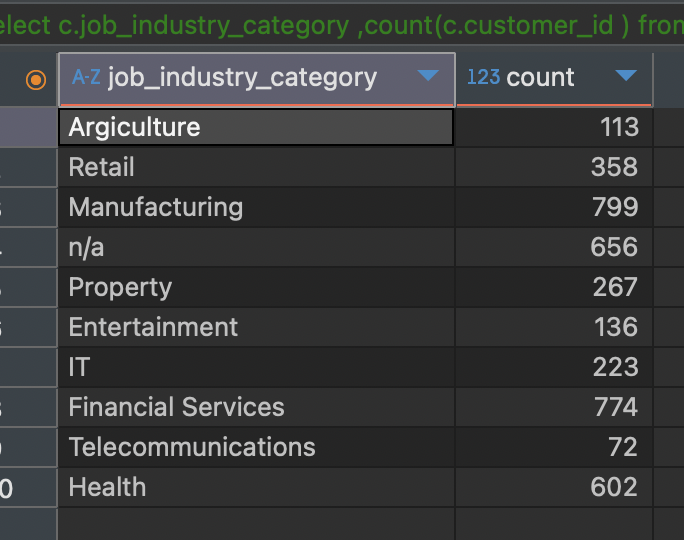
## 2. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.
```sql
select date_trunc('month', t.transaction_date) as month,
	c.job_industry_category,
	sum(replace(t.list_price, ',', '.')::numeric) as total
from transaction t
join customer c
on t.customer_id = c.customer_id
group by date_trunc('month', t.transaction_date), c.job_industry_category
order by month, c.job_industry_category
```
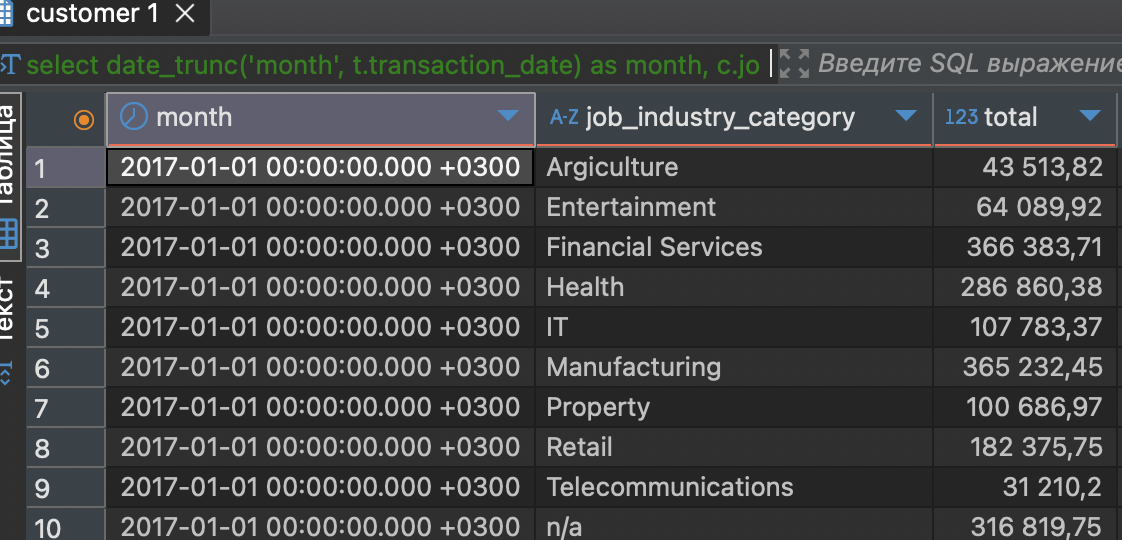
## 3. Вывести количество онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT.
```sql
select t.brand AS brand, count(*) as orders
from "transaction" t
join customer c 
	on t.customer_id = c.customer_id 
where c.job_industry_category = 'IT'
and t.order_status = 'Approved'
and t.online_order = true
group by t.brand
```
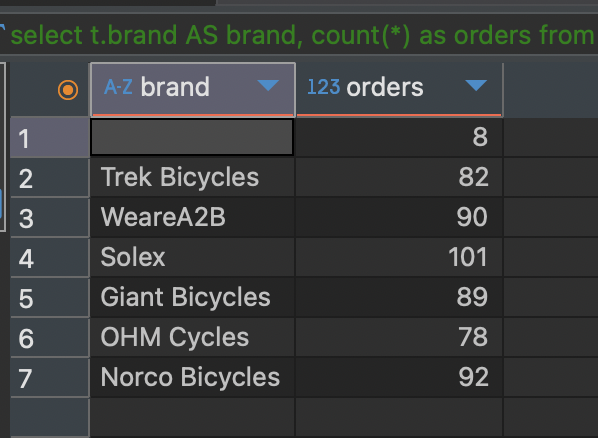
## 4. Найти по всем клиентам сумму всех транзакций (list_price), максимум, минимум и количество транзакций, отсортировав результат по убыванию суммы транзакций и количества клиентов.
### 4.1. С использованием group by
```sql
select
	t.customer_id,
	sum(replace(t.list_price, ',', '.')::numeric) as total_sum,
	max(replace(t.list_price, ',', '.')::numeric) as max_sum,
	min(replace(t.list_price, ',', '.')::numeric) as min_sum,
	count(*) as t_count
from "transaction" t 
group by t.customer_id
order by total_sum desc, t_count desc
```
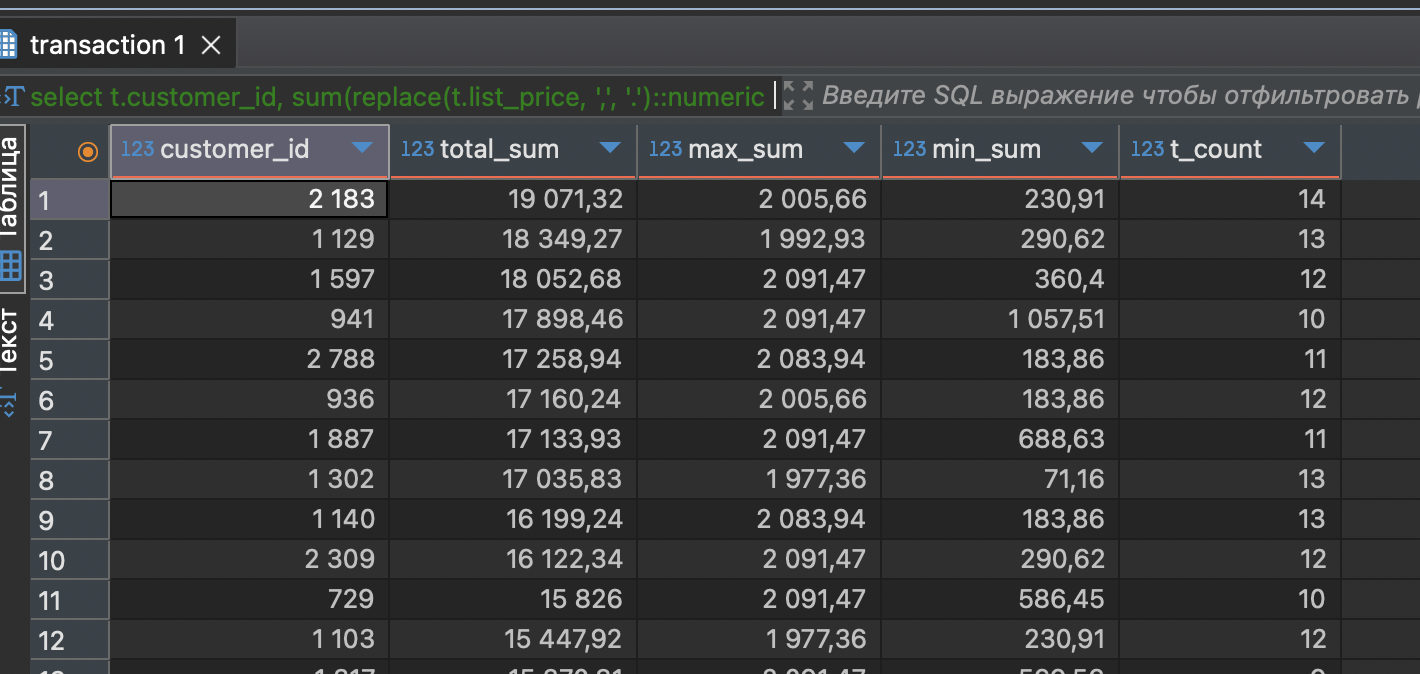
### 4.2. С использованием оконных функций
```sql
select distinct
    t.customer_id,
    sum(replace(t.list_price, ',', '.')::numeric) over (partition by t.customer_id) as total_sum,
    max(replace(t.list_price, ',', '.')::numeric) over (partition by t.customer_id) as max_sum,
    min(replace(t.list_price, ',', '.')::numeric) over (partition by t.customer_id) as min_sum,
    count(*) over (partition by t.customer_id) as t_count
from "transaction" t
order by total_sum desc, t_count desc
```
select distinct
    t.customer_id,
    sum(replace(t.list_price, ',', '.')::numeric) over (partition by t.customer_id) as total_sum,
    max(replace(t.list_price, ',', '.')::numeric) over (partition by t.customer_id) as max_sum,
    min(replace(t.list_price, ',', '.')::numeric) over (partition by t.customer_id) as min_sum,
    count(*) over (partition by t.customer_id) as t_count
from "transaction" t
order by total_sum desc, t_count desc
## 5. Найти имена и фамилии клиентов с минимальной/максимальной суммой транзакций за весь период (сумма транзакций не может быть null).
### 5.1. Имена и фамилии клиентов с максимальной суммой заказом
```sql
select c.first_name,
       c.last_name,
       s.total_amount
from (
    select customer_id,
           sum(replace(list_price, ',', '.')::numeric) as total_amount
    from transaction
    group by customer_id
) as s
join customer as c
on c.customer_id = s.customer_id
where s.total_amount = (
	select max(sub.total_amount)
	from (
		select customer_id, sum(replace(list_price, ',', '.')::numeric) as total_amount 
		from transaction
		group by customer_id) as sub)
```
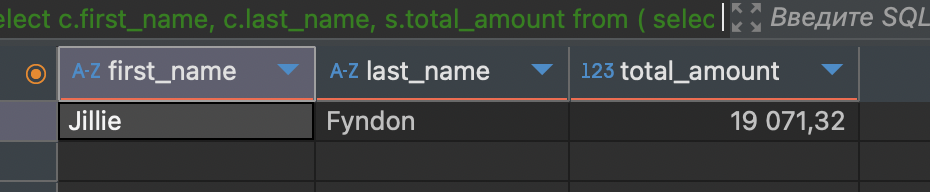
### 5.2. Имена и фамилии клиентов с минимальной суммой заказа
```sql
select c.first_name,
       c.last_name,
       s.total_amount
from (
    select customer_id,
           sum(replace(list_price, ',', '.')::numeric) as total_amount
    from transaction
    group by customer_id
) as s
join customer as c
on c.customer_id = s.customer_id
where s.total_amount = (
	select min(sub.total_amount)
	from (
		select customer_id, sum(replace(list_price, ',', '.')::numeric) as total_amount 
		from transaction
		group by customer_id) as sub)
```
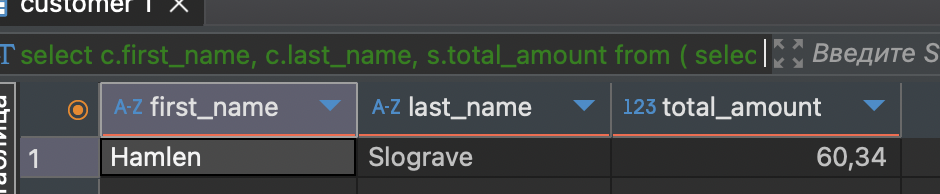
## 6. Вывести только самые первые транзакции клиентов. Решить с помощью оконных функций.
```sql
select
    c.customer_id,
    c.first_name,
    c.last_name,
    t_sub.transaction_id,
    t_sub.transaction_date
from (
	select t, *,
	row_number() over (partition by customer_id order by transaction_date) as rn
	from transaction as t) as t_sub
join customer as c
	on c.customer_id = t_sub.customer_id 
where t_sub.rn = 1
```
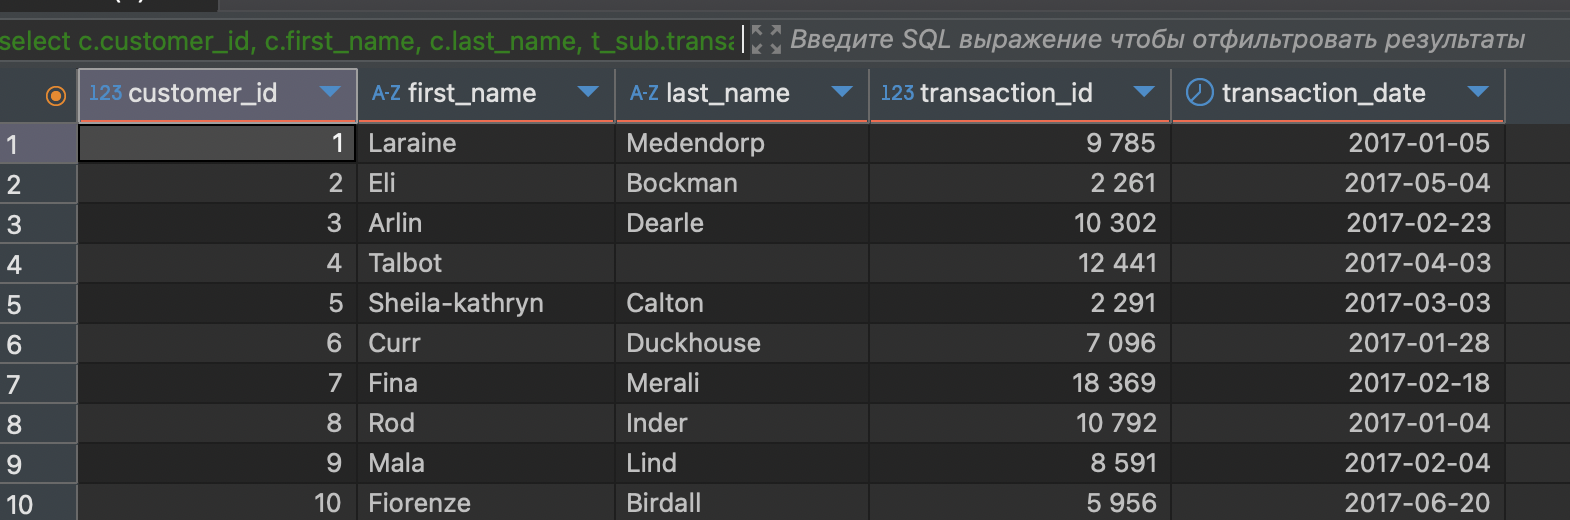
## 7. Вывести имена, фамилии и профессии клиентов, между транзакциями которых был максимальный интервал (интервал вычисляется в днях)
```sql
select 
    c.first_name,
    c.last_name,
    c.job_title,
    t.days
from customer c
join (
    select 
        customer_id,
        max(transaction_date) - min(transaction_date) as days,
        rank() over (order by max(transaction_date) - min(transaction_date) desc) as rnk
    from transaction
    group by customer_id
) as t on c.customer_id = t.customer_id
where t.rnk = 1
```
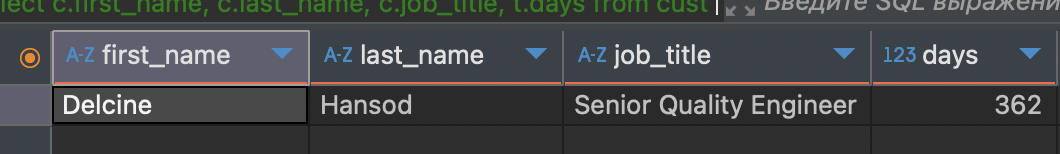